<font size='9'> Final Project  (HongyiZhang KunLiu JinghaoWang YishaXu)

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

df_train=pd.read_csv("C:\\Users\\zhy92\\Desktop\\Stevens Master\\Classes\\2020 Spring\\MA -641-A Time Series Analysis I\\Final(Weather data)\\data set from kaggle\\train.csv",parse_dates=['timestamp'])

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.ticker as ticker

In [33]:
df_building=pd.read_csv("C:\\Users\\zhy92\\Desktop\\Stevens Master\\Classes\\2020 Spring\\MA -641-A Time Series Analysis I\\Final(Weather data)\\data set from kaggle\\building_metadata.csv")

In [34]:
df_train_total = pd.merge(df_train,df_building,how='left',on='building_id')

df_train_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 9 columns):
building_id      int64
meter            int64
timestamp        datetime64[ns]
meter_reading    float64
site_id          int64
primary_use      object
square_feet      int64
year_built       float64
floor_count      float64
dtypes: datetime64[ns](1), float64(3), int64(4), object(1)
memory usage: 1.5+ GB


<font size='9'> Reduce memory

In [35]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

reduce_mem_usage(df_train_total,use_float16=True)

Memory usage of dataframe is 1542.37 MB
Memory usage after optimization is: 636.23 MB
Decreased by 58.7%


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,NaN
...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,NaN
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,NaN,NaN
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,NaN
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,NaN


<font size='9'> Group data by Meter type

In [36]:
meter0=df_train_total[(df_train_total.meter==0)& (df_train_total.meter_reading>0)]

meter0

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
45,46,0,2016-01-01 00:00:00,53.239700,0,Retail,9045,2016.0,NaN
72,74,0,2016-01-01 00:00:00,43.001301,0,Parking,387638,1997.0,NaN
91,93,0,2016-01-01 00:00:00,52.420601,0,Office,33370,1982.0,NaN
103,105,0,2016-01-01 00:00:00,23.303600,1,Education,50623,NaN,5.0
104,106,0,2016-01-01 00:00:00,0.374600,1,Education,5374,NaN,4.0
...,...,...,...,...,...,...,...,...,...
20216094,1443,0,2016-12-31 23:00:00,64.949997,15,Education,40311,1913.0,NaN
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,NaN
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,NaN,NaN
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,NaN


In [37]:
meter1=df_train_total[(df_train_total.meter==1)& (df_train_total.meter_reading>0)]

meter1

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
176,163,1,2016-01-01 00:00:00,4.571900,2,Education,72102,1970.0,NaN
181,166,1,2016-01-01 00:00:00,209.886002,2,Lodging/residential,553210,2009.0,NaN
187,168,1,2016-01-01 00:00:00,51.556999,2,Education,183460,2005.0,NaN
190,169,1,2016-01-01 00:00:00,176.686005,2,Education,179559,2006.0,NaN
193,170,1,2016-01-01 00:00:00,11.289100,2,Retail,45224,1982.0,NaN
...,...,...,...,...,...,...,...,...,...
20216035,1407,1,2016-12-31 23:00:00,11.032500,15,Lodging/residential,83141,2006.0,NaN
20216037,1408,1,2016-12-31 23:00:00,9.415200,15,Entertainment/public assembly,28760,2007.0,NaN
20216039,1409,1,2016-12-31 23:00:00,18.812000,15,Lodging/residential,48881,1902.0,NaN
20216042,1410,1,2016-12-31 23:00:00,16.700001,15,Office,11524,1994.0,NaN


In [38]:
meter2=df_train_total[(df_train_total.meter==2)& (df_train_total.meter_reading>0)]

meter2

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
898,747,2,2016-01-01 00:00:00,120.786003,6,Education,30531,NaN,NaN
902,750,2,2016-01-01 00:00:00,4678.140137,6,Education,35990,NaN,NaN
906,753,2,2016-01-01 00:00:00,324.226013,6,Education,39558,NaN,NaN
910,757,2,2016-01-01 00:00:00,918.984009,6,Education,46813,NaN,NaN
912,758,2,2016-01-01 00:00:00,256.165985,6,Lodging/residential,47007,NaN,NaN
...,...,...,...,...,...,...,...,...,...
20216081,1434,2,2016-12-31 23:00:00,259.072998,15,Education,33148,1967.0,NaN
20216084,1436,2,2016-12-31 23:00:00,1274.660034,15,Manufacturing/industrial,11302,1937.0,NaN
20216086,1437,2,2016-12-31 23:00:00,1518.920044,15,Education,111518,1968.0,NaN
20216088,1438,2,2016-12-31 23:00:00,852.770020,15,Education,108971,1990.0,NaN


In [39]:
meter3=df_train_total[(df_train_total.meter==3)& (df_train_total.meter_reading>0)]

meter3

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
113,112,3,2016-01-01 00:00:00,96.977997,1,Education,32206,NaN,6.0
115,113,3,2016-01-01 00:00:00,19.597000,1,Education,100481,1958.0,9.0
117,114,3,2016-01-01 00:00:00,100.000000,1,Education,139683,1958.0,13.0
121,117,3,2016-01-01 00:00:00,19.680901,1,Education,15489,2004.0,4.0
124,119,3,2016-01-01 00:00:00,200.000000,1,Education,91149,2007.0,7.0
...,...,...,...,...,...,...,...,...,...
20215844,1322,3,2016-12-31 23:00:00,2476.610107,14,Entertainment/public assembly,166489,NaN,NaN
20215847,1323,3,2016-12-31 23:00:00,1909.329956,14,Office,87200,NaN,NaN
20215850,1324,3,2016-12-31 23:00:00,364.019012,14,Entertainment/public assembly,84688,NaN,NaN
20215852,1325,3,2016-12-31 23:00:00,156.050003,15,Entertainment/public assembly,155177,1915.0,NaN


In [40]:
df_mt_0_train_ts = meter0[['timestamp','meter_reading']]
df_mt_1_train_ts = meter1[['timestamp','meter_reading']]
df_mt_2_train_ts = meter2[['timestamp','meter_reading']]
df_mt_3_train_ts = meter3[['timestamp','meter_reading']]

In [41]:
df_mt_0_train_ts.set_index('timestamp', inplace=True)
df_mt_1_train_ts.set_index('timestamp', inplace=True)
df_mt_2_train_ts.set_index('timestamp', inplace=True)
df_mt_3_train_ts.set_index('timestamp', inplace=True)

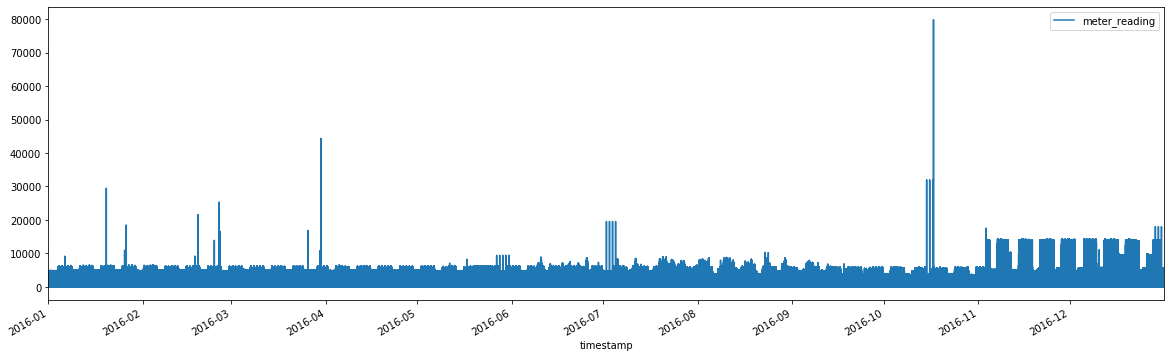

In [42]:
df_mt_0_train_ts.plot(figsize=(20, 6))

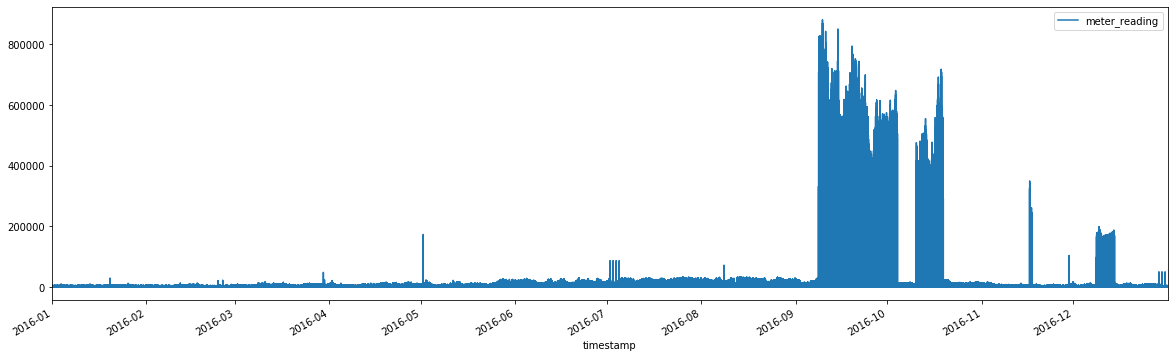

In [43]:
df_mt_1_train_ts.plot(figsize=(20, 6))

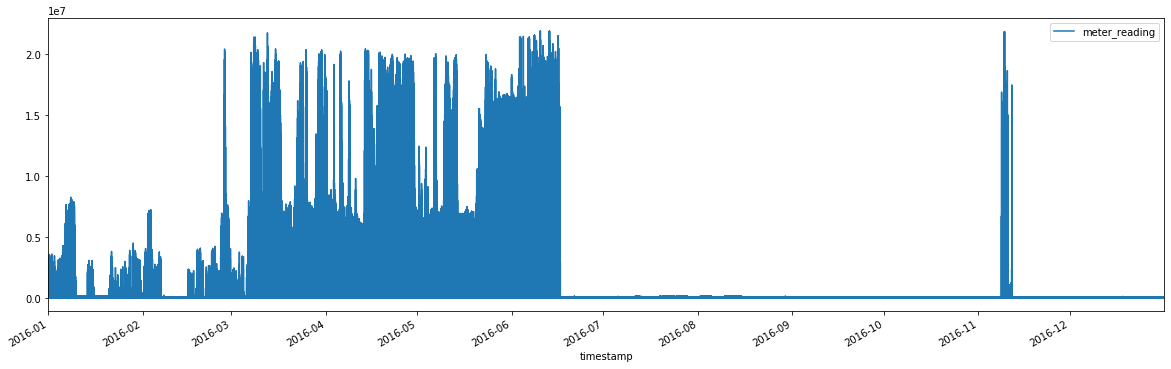

In [44]:
df_mt_2_train_ts.plot(figsize=(20, 6))

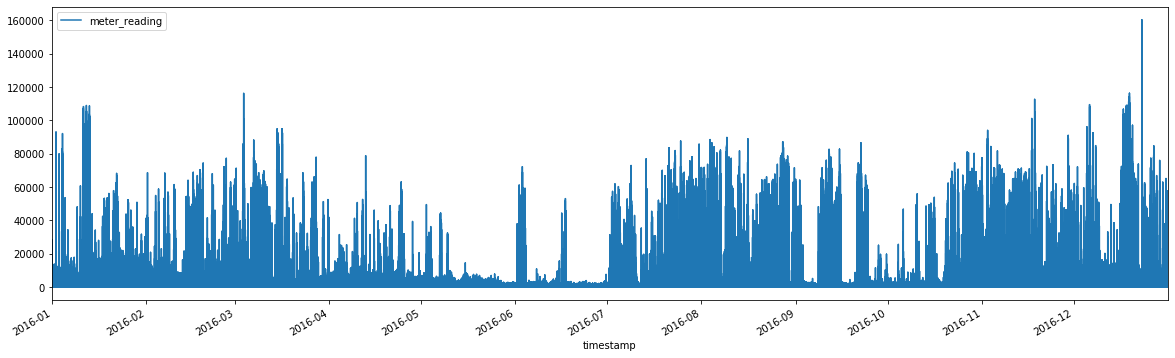

In [45]:
df_mt_3_train_ts.plot(figsize=(20, 6))

In [46]:
df_mt_0_train_ts_w=df_mt_0_train_ts.meter_reading.resample('w').sum()
df_mt_1_train_ts_w=df_mt_1_train_ts.meter_reading.resample('w').sum()
df_mt_2_train_ts_w=df_mt_2_train_ts.meter_reading.resample('w').sum()
df_mt_3_train_ts_w=df_mt_3_train_ts.meter_reading.resample('w').sum()

<font size='9'> Weekly Meter plot

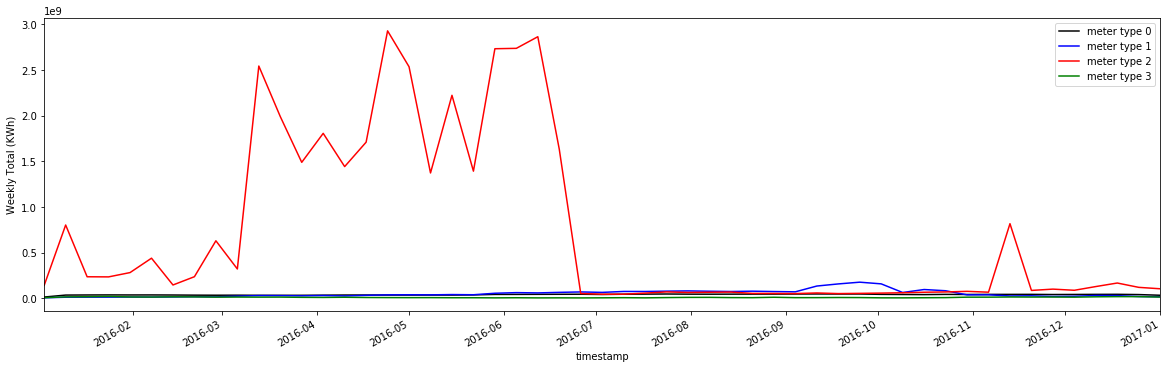

In [48]:
fig, ax2 = plt.subplots(figsize=(20, 6))
ax2.plot(df_mt_0_train_ts_w, color='black', label='meter type 0')
df_mt_1_train_ts_w.plot(label='meter type 1',color='blue')
df_mt_2_train_ts_w.plot(label='meter type 2',color='red')
df_mt_3_train_ts_w.plot(label='meter type 3',color='green')
ax2.legend()
ax2.set_ylabel('Weekly Total (KWh)');

<font size='9'> Decompose

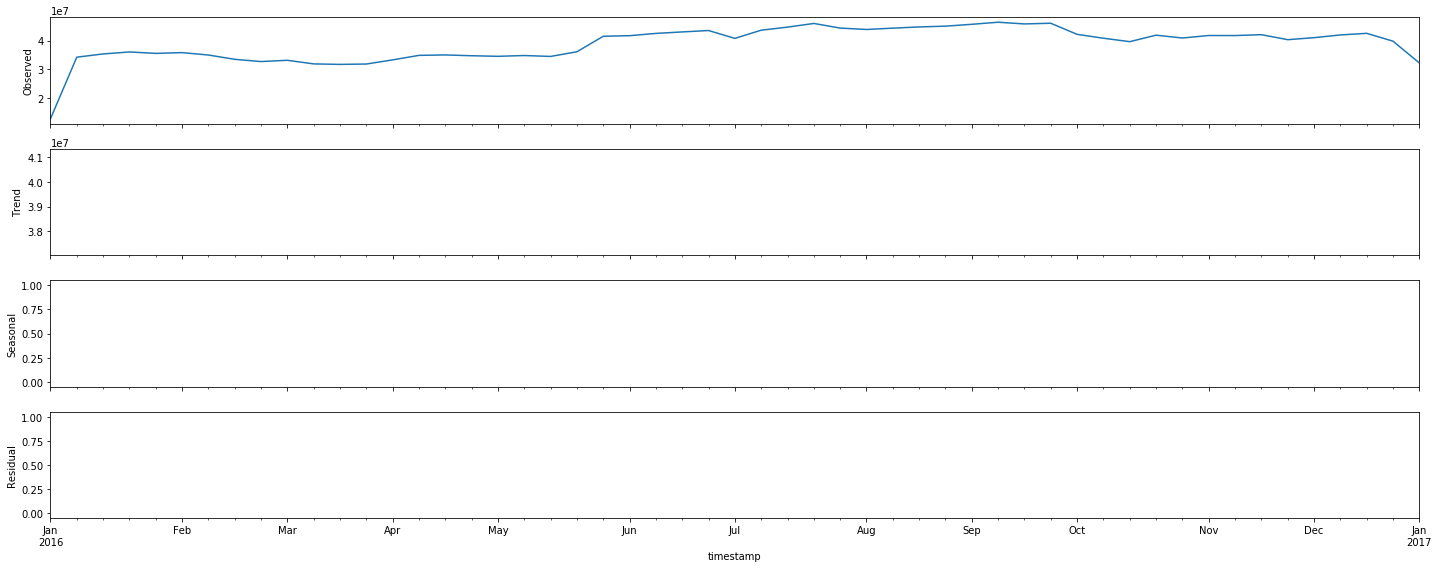

In [53]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(df_mt_0_train_ts_w, model='additive')
fig = decomposition.plot()

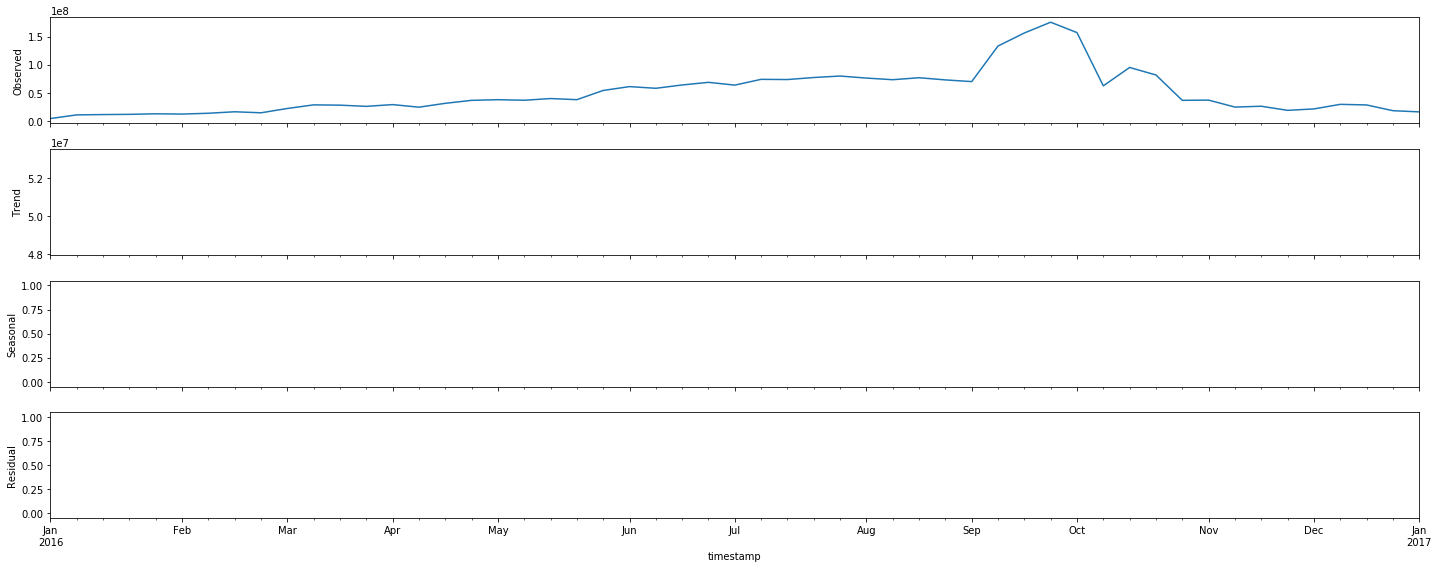

In [54]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(df_mt_1_train_ts_w, model='additive')
fig = decomposition.plot()

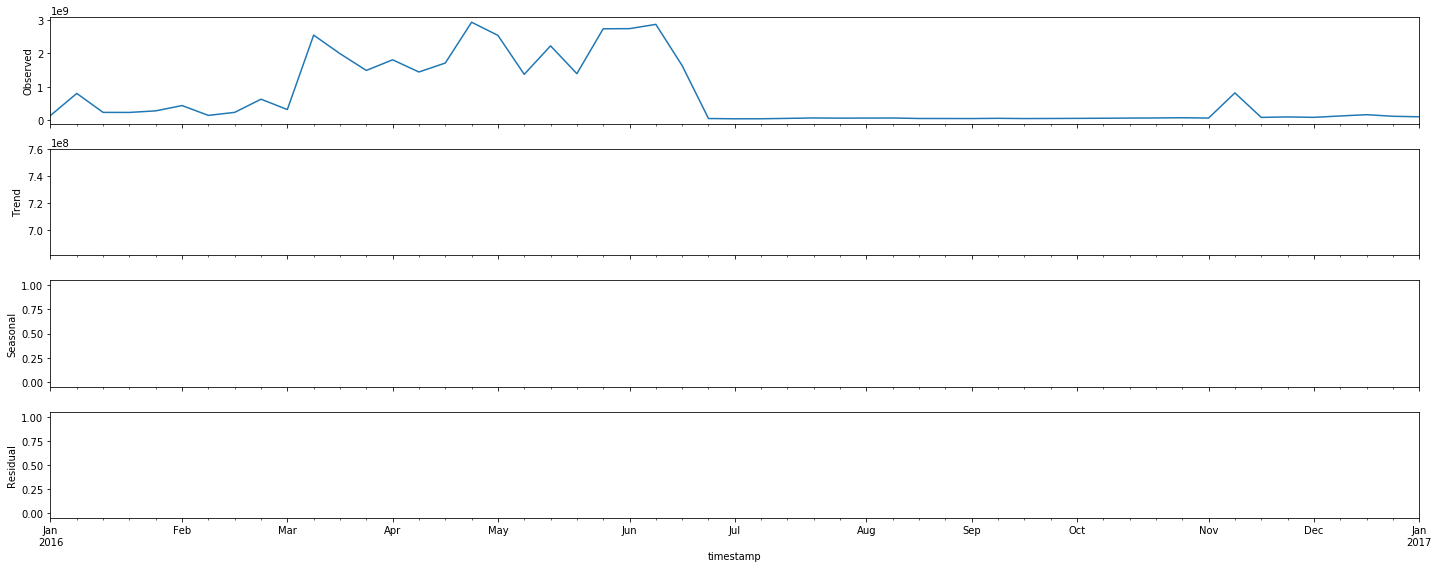

In [55]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(df_mt_2_train_ts_w, model='additive')
fig = decomposition.plot()

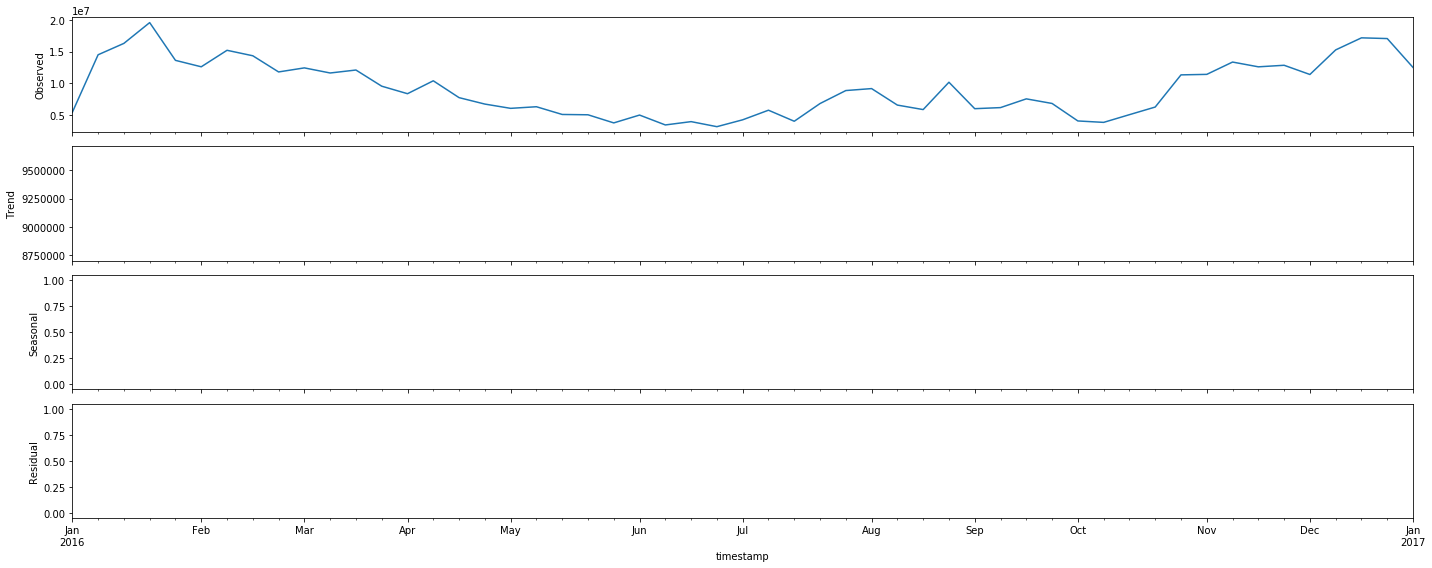

In [56]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(df_mt_3_train_ts_w, model='additive')
fig = decomposition.plot()

<font size='9'> Test stationary

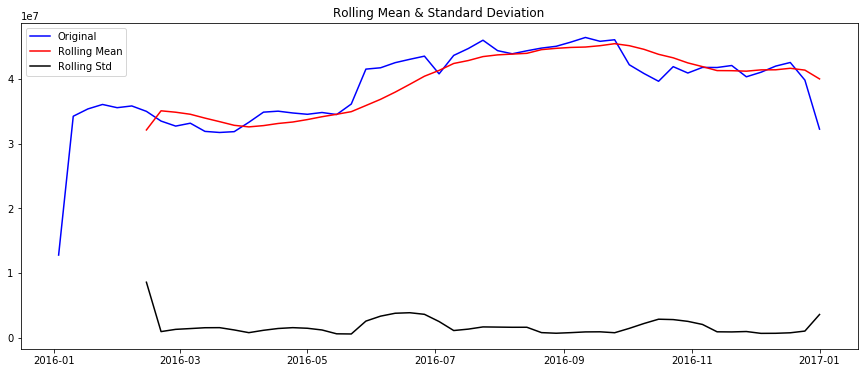

Results of Dickey-Fuller Test:
Test Statistic                 -1.059295
p-value                         0.731029
#Lags Used                      1.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64


In [59]:
from statsmodels.tsa.stattools import adfuller  #Dickey-Fuller test
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  #autolag : {‘AIC’, ‘BIC’, ‘t-stat’, None}
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df_mt_0_train_ts_w)

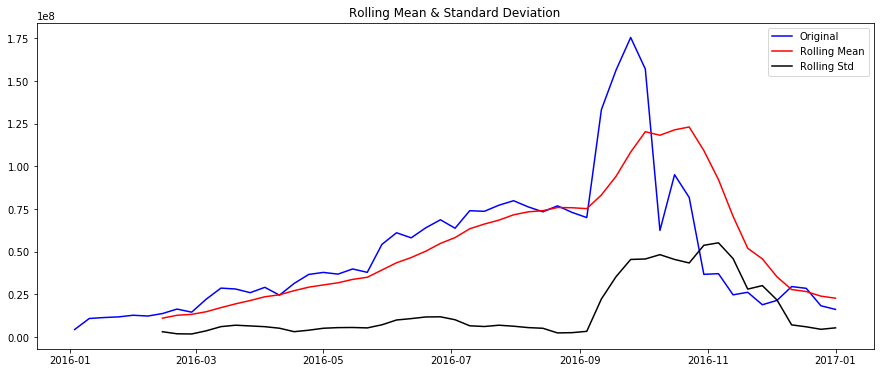

Results of Dickey-Fuller Test:
Test Statistic                 -1.884399
p-value                         0.339435
#Lags Used                      0.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [60]:
test_stationarity(df_mt_1_train_ts_w)

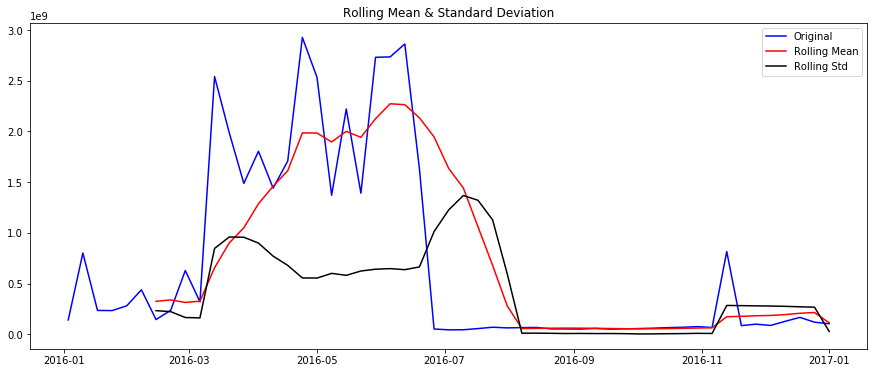

Results of Dickey-Fuller Test:
Test Statistic                 -2.345888
p-value                         0.157595
#Lags Used                      0.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [61]:
test_stationarity(df_mt_2_train_ts_w)

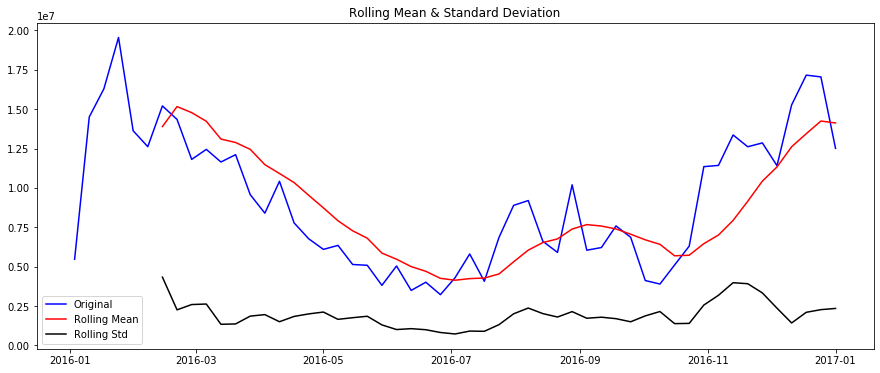

Results of Dickey-Fuller Test:
Test Statistic                 -2.178179
p-value                         0.214260
#Lags Used                      0.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [62]:
test_stationarity(df_mt_3_train_ts_w)

<font size='9'> First difference Transformation

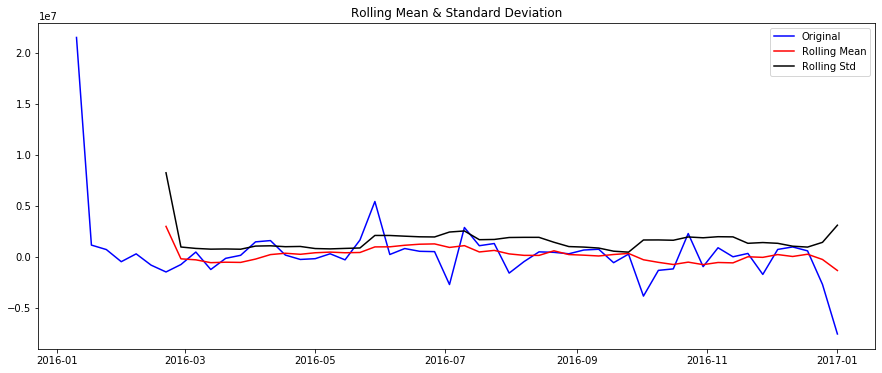

Results of Dickey-Fuller Test:
Test Statistic                -1.183746e+01
p-value                        7.730170e-22
#Lags Used                     0.000000e+00
Number of Observations Used    5.100000e+01
Critical Value (1%)           -3.565624e+00
Critical Value (5%)           -2.920142e+00
Critical Value (10%)          -2.598015e+00
dtype: float64


In [117]:
test_stationarity(df_mt_0_train_ts_w.diff().dropna(inplace=False))

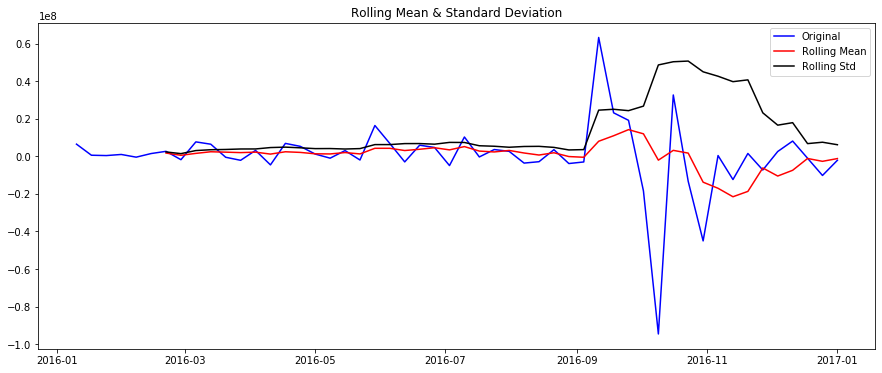

Results of Dickey-Fuller Test:
Test Statistic                -6.945687e+00
p-value                        9.986352e-10
#Lags Used                     0.000000e+00
Number of Observations Used    5.100000e+01
Critical Value (1%)           -3.565624e+00
Critical Value (5%)           -2.920142e+00
Critical Value (10%)          -2.598015e+00
dtype: float64


In [118]:
test_stationarity(df_mt_1_train_ts_w.diff().dropna(inplace=False))

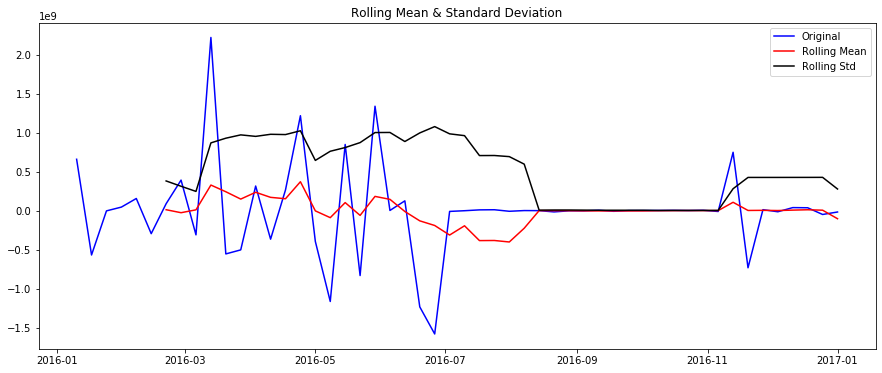

Results of Dickey-Fuller Test:
Test Statistic                -8.756006e+00
p-value                        2.754309e-14
#Lags Used                     0.000000e+00
Number of Observations Used    5.100000e+01
Critical Value (1%)           -3.565624e+00
Critical Value (5%)           -2.920142e+00
Critical Value (10%)          -2.598015e+00
dtype: float64


In [119]:
test_stationarity(df_mt_2_train_ts_w.diff().dropna(inplace=False))

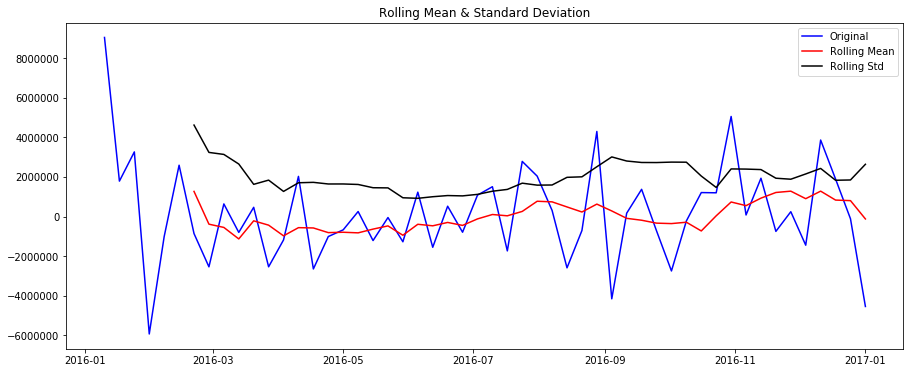

Results of Dickey-Fuller Test:
Test Statistic                -8.216412e+00
p-value                        6.605793e-13
#Lags Used                     0.000000e+00
Number of Observations Used    5.100000e+01
Critical Value (1%)           -3.565624e+00
Critical Value (5%)           -2.920142e+00
Critical Value (10%)          -2.598015e+00
dtype: float64


In [120]:
test_stationarity(df_mt_3_train_ts_w.diff().dropna(inplace=False))

<font size='9'> Acf and Pacf for different meter types

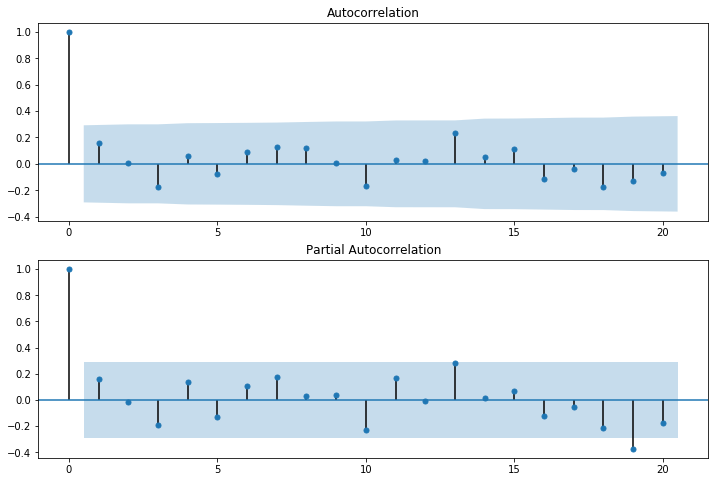

In [73]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_mt_0_train_ts_w.diff().iloc[8:], lags=20, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_mt_0_train_ts_w.diff().iloc[8:], lags=20, ax=ax2)

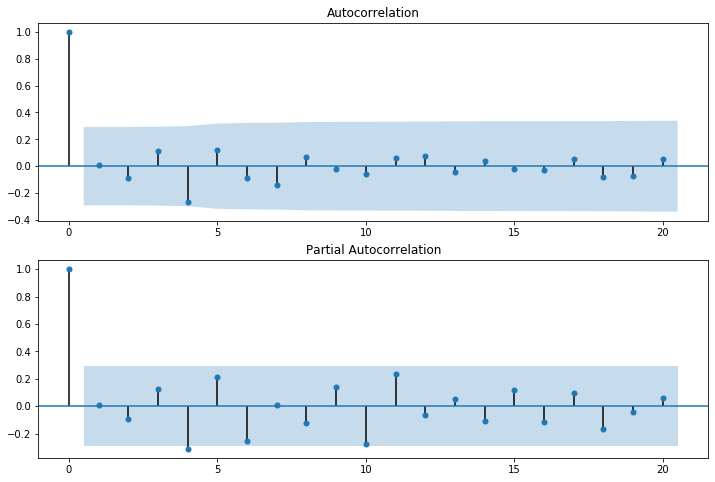

In [74]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_mt_1_train_ts_w.diff().iloc[8:], lags=20, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_mt_1_train_ts_w.diff().iloc[8:], lags=20, ax=ax2)

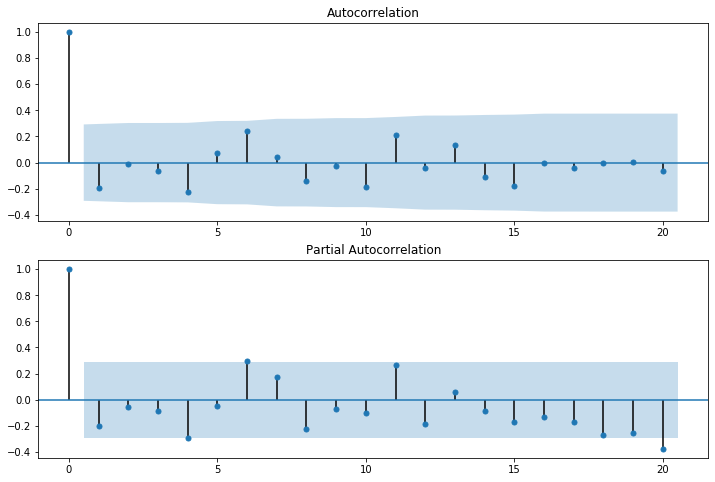

In [75]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_mt_2_train_ts_w.diff().iloc[8:], lags=20, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_mt_2_train_ts_w.diff().iloc[8:], lags=20, ax=ax2)

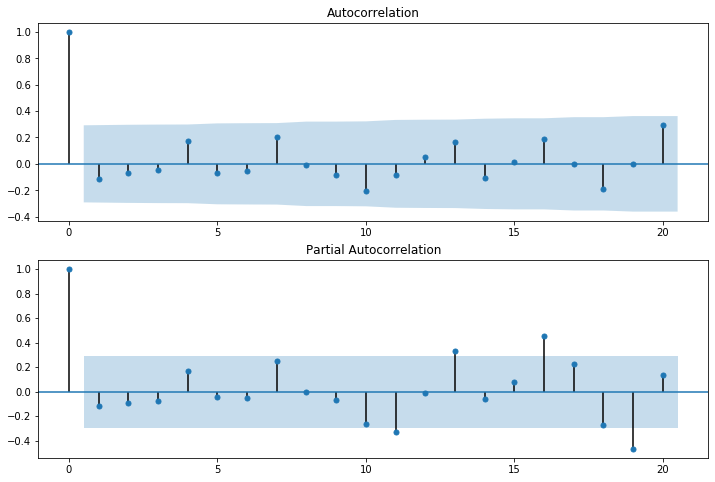

In [76]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_mt_3_train_ts_w.diff().iloc[8:], lags=20, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_mt_3_train_ts_w.diff().iloc[8:], lags=20, ax=ax2)

<font size='9'> ARIMA models

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.meter_reading   No. Observations:                   52
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -855.643
Method:                       css-mle   S.D. of innovations        3381956.529
Date:                Sun, 10 May 2020   AIC                           1719.286
Time:                        17:13:50   BIC                           1727.091
Sample:                    01-10-2016   HQIC                          1722.279
                         - 01-01-2017                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3.746e+05   8.02e+05      0.467      0.642    -1.2e+06    1.95e+06
ar.L1.D.meter_reading     0.4516      0.509      0.887      0.379      -0.546       1.449
ma.L1.D.meter_reading    -0.0507      0.458     -0.111      0.912      -0.949       0.847
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2142           +0.0000j            2.2142            0.0000
MA.1           19.7287           +0.0000j           19.7287            0.0000
-----------------------------------------------------------------------------
"""

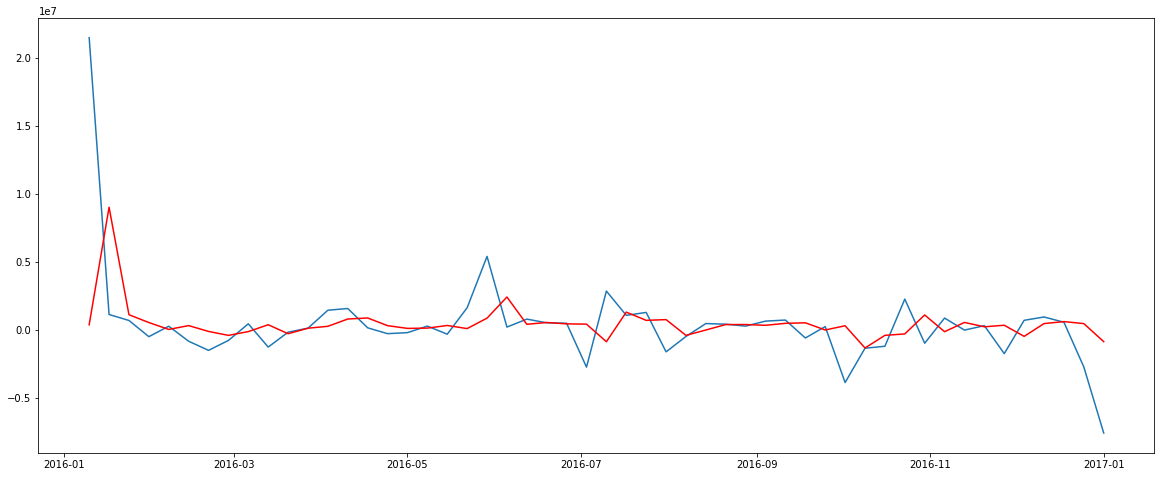

In [95]:
model_0 = ARIMA(df_mt_0_train_ts_w, order=(1,1,1))  
results_AR_0 = model_0.fit(disp=-1)  
plt.plot(df_mt_0_train_ts_w.diff())
plt.plot(results_AR_0.fittedvalues, color='red')
results_AR_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.meter_reading   No. Observations:                   52
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -944.255
Method:                       css-mle   S.D. of innovations       18513926.526
Date:                Sun, 10 May 2020   AIC                           1896.511
Time:                        17:06:55   BIC                           1904.316
Sample:                    01-10-2016   HQIC                          1899.503
                         - 01-01-2017                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2.267e+05   2.07e+06      0.109      0.913   -3.83e+06    4.29e+06
ma.L1.D.meter_reading     0.2298      0.142      1.624      0.111      -0.048       0.507
ma.L2.D.meter_reading    -0.4355      0.154     -2.822      0.007      -0.738      -0.133
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.2743           +0.0000j            1.2743            0.5000
MA.2            1.8020           +0.0000j            1.8020            0.0000
-----------------------------------------------------------------------------
"""

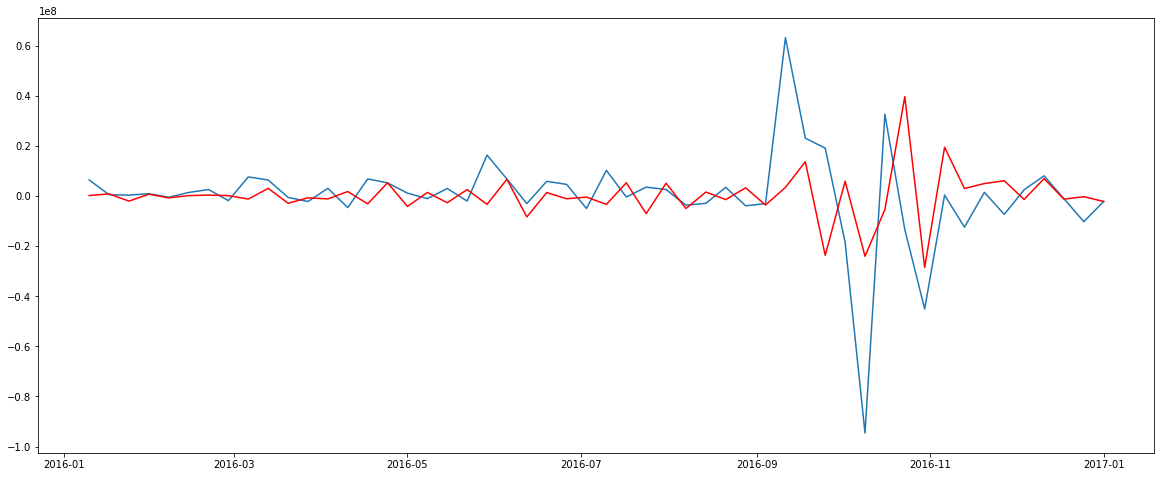

In [87]:
model_1 = ARIMA(df_mt_1_train_ts_w, order=(0,1,2))  
results_AR_1 = model_1.fit(disp=-1)  
plt.plot(df_mt_1_train_ts_w.diff())
plt.plot(results_AR_1.fittedvalues, color='red')
results_AR_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.meter_reading   No. Observations:                   52
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -944.255
Method:                       css-mle   S.D. of innovations       18513926.526
Date:                Sun, 10 May 2020   AIC                           1896.511
Time:                        17:08:32   BIC                           1904.316
Sample:                    01-10-2016   HQIC                          1899.503
                         - 01-01-2017                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2.267e+05   2.07e+06      0.109      0.913   -3.83e+06    4.29e+06
ma.L1.D.meter_reading     0.2298      0.142      1.624      0.111      -0.048       0.507
ma.L2.D.meter_reading    -0.4355      0.154     -2.822      0.007      -0.738      -0.133
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.2743           +0.0000j            1.2743            0.5000
MA.2            1.8020           +0.0000j            1.8020            0.0000
-----------------------------------------------------------------------------
"""

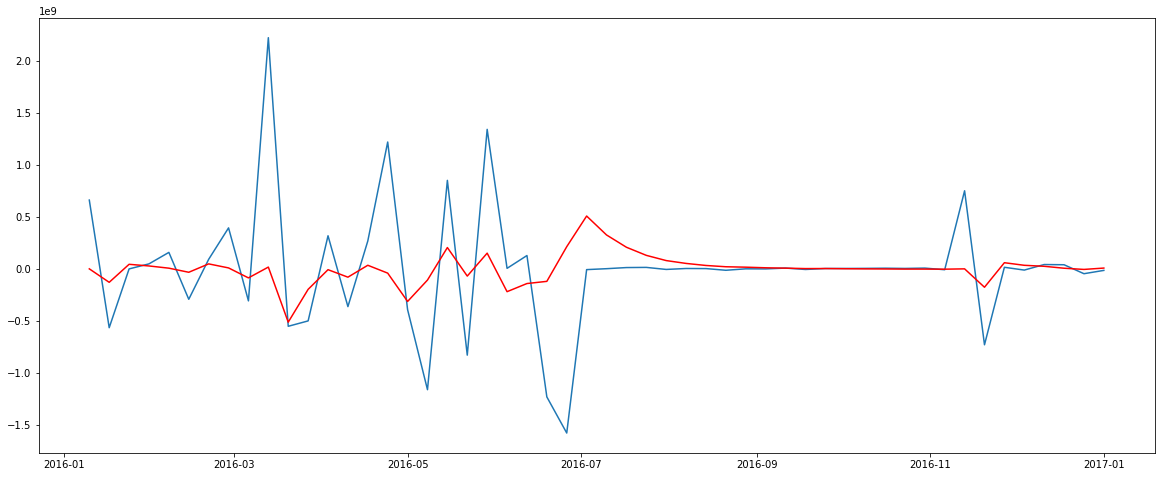

In [89]:
model_2 = ARIMA(df_mt_2_train_ts_w, order=(1,1,1))  
results_AR_2 = model_2.fit(disp=-1)  
plt.plot(df_mt_2_train_ts_w.diff())
plt.plot(results_AR_2.fittedvalues, color='red')
results_AR_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.meter_reading   No. Observations:                   52
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -944.255
Method:                       css-mle   S.D. of innovations       18513926.526
Date:                Sun, 10 May 2020   AIC                           1896.511
Time:                        17:09:32   BIC                           1904.316
Sample:                    01-10-2016   HQIC                          1899.503
                         - 01-01-2017                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2.267e+05   2.07e+06      0.109      0.913   -3.83e+06    4.29e+06
ma.L1.D.meter_reading     0.2298      0.142      1.624      0.111      -0.048       0.507
ma.L2.D.meter_reading    -0.4355      0.154     -2.822      0.007      -0.738      -0.133
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.2743           +0.0000j            1.2743            0.5000
MA.2            1.8020           +0.0000j            1.8020            0.0000
-----------------------------------------------------------------------------
"""

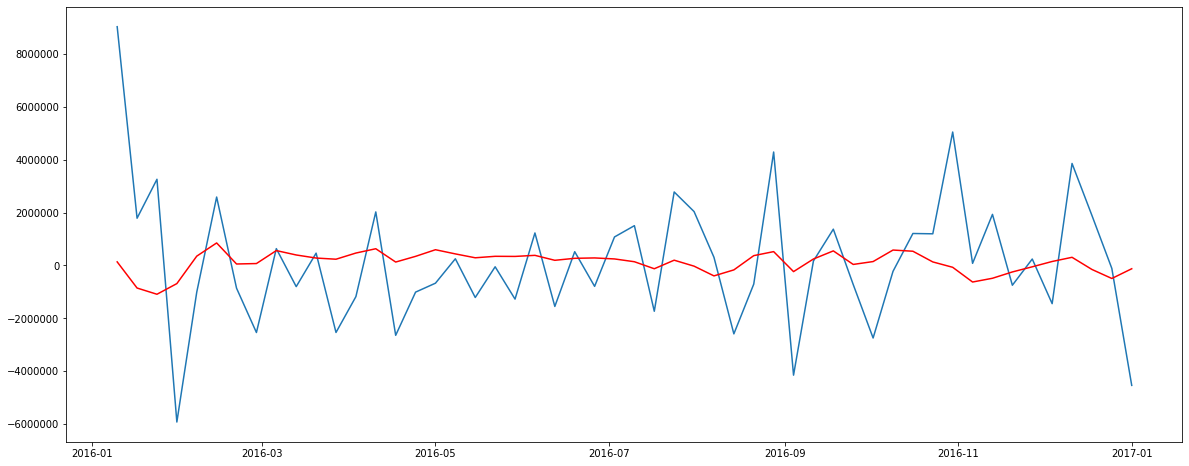

In [93]:
model_3 = ARIMA(df_mt_3_train_ts_w, order=(0,1,2))  
results_AR_3 = model_3.fit(disp=-1)  
plt.plot(df_mt_3_train_ts_w.diff())
plt.plot(results_AR_3.fittedvalues, color='red')
results_AR_1.summary()

<font size='9'> Forecasting

2017-01-08    2.935697e+07
2017-01-15    2.826251e+07
2017-01-22    2.797363e+07
2017-01-29    2.804859e+07
2017-02-05    2.828786e+07
                  ...     
2018-12-09    6.413810e+07
2018-12-16    6.451270e+07
2018-12-23    6.488730e+07
2018-12-30    6.526190e+07
2019-01-06    6.563650e+07
Freq: W-SUN, Length: 105, dtype: float64


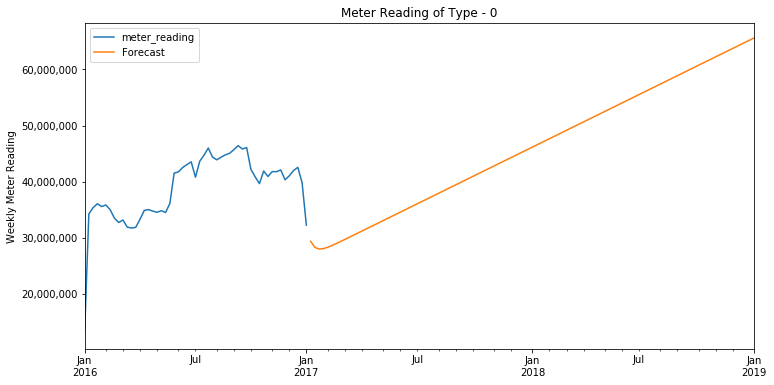

In [133]:
fcast_0 = results_AR_0.predict(len(df_mt_0_train_ts_w),len(df_mt_0_train_ts_w)+104,dynamic=False, typ='levels')
formatter = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Meter Reading of Type - 0'
ylabel='Weekly Meter Reading'
xlabel='' # we don't really need a label here

ax = df_mt_0_train_ts_w.plot(legend=True,figsize=(12,6),title=title)
fcast_0.plot(legend=True,label='Forecast')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

print(fcast_0)

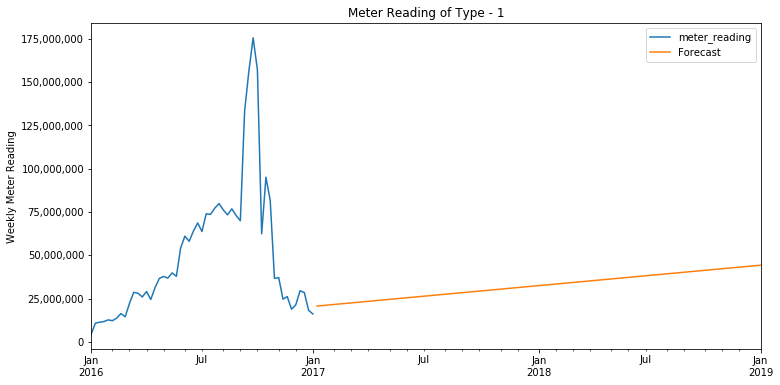

In [134]:
fcast_1 = results_AR_1.predict(len(df_mt_1_train_ts_w),len(df_mt_1_train_ts_w)+104,dynamic=False, typ='levels')
formatter = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Meter Reading of Type - 1'
ylabel='Weekly Meter Reading'
xlabel='' # we don't really need a label here

ax = df_mt_1_train_ts_w.plot(legend=True,figsize=(12,6),title=title)
fcast_1.plot(legend=True,label='Forecast')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

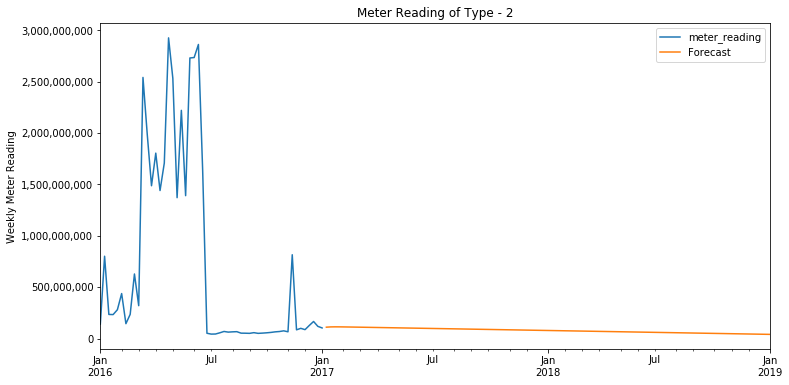

In [135]:
fcast_2 = results_AR_2.predict(len(df_mt_2_train_ts_w),len(df_mt_2_train_ts_w)+104,dynamic=False, typ='levels')
formatter = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Meter Reading of Type - 2'
ylabel='Weekly Meter Reading'
xlabel='' # we don't really need a label here

ax = df_mt_2_train_ts_w.plot(legend=True,figsize=(12,6),title=title)
fcast_2.plot(legend=True,label='Forecast')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

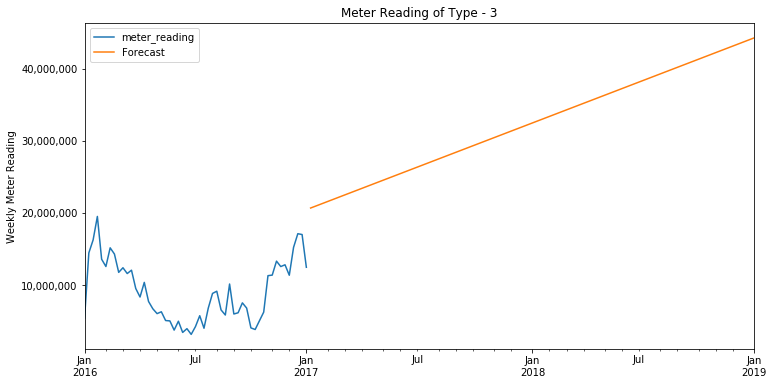

In [136]:
fcast_3 = results_AR_3.predict(len(df_mt_3_train_ts_w),len(df_mt_3_train_ts_w)+104,dynamic=False, typ='levels')
formatter = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Meter Reading of Type - 3'
ylabel='Weekly Meter Reading'
xlabel='' # we don't really need a label here

ax = df_mt_3_train_ts_w.plot(legend=True,figsize=(12,6),title=title)
fcast_1.plot(legend=True,label='Forecast')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);